In [1]:
import numpy as np
import math
import scipy.special as scspec
from method_runner import FirstOrderAlgorithmRunner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def logistic_func(w, X, y, C=1.0):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (N,)
        C: positive float, default: 1.0
        
        funcw: np.float 
    '''
    return np.logaddexp(0, -y * (X @ w)).sum() + C * w @ w / 2.0

In [3]:
def logistic_grad(w, X, y, C=1.0):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (N,)
        C: positive float, default: 1.0
        
        gradw: np.array размера (M,)
    '''
    return w * C - (X.T * y * scspec.expit(-y * (X @ w))).sum(axis=1)

In [4]:
def grad_simple(x0, func, grad, verbose=True, max_iter=20, eps=0.01):    
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    grad_count, func_count = 0, 0
    for iter in range(max_iter):
        fvalx, gradx = func(x), grad(x)
        grad_count += 1
        func_count += 1
        alpha = 1 / np.sqrt(iter + 1)
        x = x - alpha * gradx
        xvals.append(x)
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))
        if ngrads[-1] < eps:
            break
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [5]:
def ogmg(x0, func, grad, verbose=True, L=1, mu=1):
    N = math.ceil(math.sqrt(8 * L / mu))
    theta = np.ones(N + 1)
    for i in range(N - 1, 0, -1):
        theta[i] = (1 + math.sqrt(1 + 4 * theta[i+1] * theta[i+1]))/2
    theta[0] = (1 + math.sqrt(1 + 8 * theta[1] * theta[1]))/2
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    y = x
    grad_count, func_count = 0, 0
    for i in range(N):
        fvalx, gradx = func(x), grad(x)
        grad_count += 1
        func_count += 1
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))
        y_new = x - gradx / L
        beta = (theta[i] - 1) * (2 * theta[i + 1] - 1) / theta[i] / (2 * theta[i] - 1)
        gamma = (2 * theta[i + 1] - 1) / (2 * theta[i] - 1)
        x = y_new + beta * (y_new - y) + gamma * (y_new - x)
        xvals.append(x)
        y = y_new
    fvalx, gradx = func(x), grad(x)
    fvals.append(fvalx)
    ngrads.append(np.linalg.norm(gradx))
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [6]:
def ogmg_repeat(x0, func, grad, verbose=True, L=1, mu=1, eps=0.01):
    N = math.ceil(math.sqrt(8 * L / mu))
    theta = np.ones(N + 1)
    for i in range(N - 1, 0, -1):
        theta[i] = (1 + math.sqrt(1 + 4 * theta[i+1] * theta[i+1]))/2
    theta[0] = (1 + math.sqrt(1 + 8 * theta[1] * theta[1]))/2
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    y = x
    grad_count, func_count = 0, 0
    while True:
        fvalx, gradx = func(x), grad(x)
        grad_count += 1
        func_count += 1
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))
        if ngrads[-1] <= eps:
            break
        for i in range(N):            
            y_new = x - gradx / L
            beta = (theta[i] - 1) * (2 * theta[i + 1] - 1) / theta[i] / (2 * theta[i] - 1)
            gamma = (2 * theta[i + 1] - 1) / (2 * theta[i] - 1)
            x = y_new + beta * (y_new - y) + gamma * (y_new - x)
            xvals.append(x)
            y = y_new
            if i != N-1:
                fvalx, gradx = func(x), grad(x)
                fvals.append(fvalx)
                ngrads.append(np.linalg.norm(gradx))
                grad_count += 1
                func_count += 1
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [7]:
def acgm(x0, func, grad, verbose=True, L=1, mu=1, eps=0.01, beta=4):
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    grad_count, func_count = 0, 0
    change = True
    while True:
        fvalx, gradx = func(x), grad(x)
        ngx = np.linalg.norm(gradx)
        if ngx <= eps:
            break
        if change:
            mu *= beta
        else:
            change = True
        ogmg_res = ogmg(x, func, grad, verbose, L, mu)
        xvals += ogmg_res['points']
        fvals += ogmg_res['func_seq']
        ngrads += ogmg_res['grad_seq']
        grad_count += ogmg_res['grad_count']
        func_count += ogmg_res['func_count']
        if ngrads[-1] <= 0.5 * ngx:
            x = xvals[-1]
        elif ngrads[-1] <= ngx:
            x = xvals[-1]
            mu /= beta
            change = False
        else:
            mu /= beta
            change = False
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [8]:
def ugm(x0, func, grad, verbose=True, L=1, eps=0.01):
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    grad_count, func_count = 0, 0
    change = True
    while True:
        fvalx, gradx = func(x), grad(x)
        grad_count += 1
        func_count += 1
        fvals.append(fvalx)
        ngx = np.linalg.norm(gradx)
        ngrads.append(ngx)
        if ngx <= eps:
            break
        if change:
            L /= 2
        else:
            change = True
        x_new = x - gradx / L 
        f_new = func(x_new)
        xvals.append(x_new)
        fvals.append(f_new)
        ngrads.append(np.linalg.norm(x_new))
        grad_count += 1
        func_count += 1
        if f_new <= fvalx - ngx**2 / L / 2:#+ eps/2/4:
            x = x_new
            continue
        else:
            if f_new <= fvalx:
                x = x_new
            L *= 2
            change = False
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [9]:
def ogmg_l(x0, func, grad, verbose=True, L=1, mu=1, eps=0.01):
    N = math.ceil(math.sqrt(8 * L / mu))
    theta = np.ones(N + 1)
    for i in range(N - 1, 0, -1):
        theta[i] = (1 + math.sqrt(1 + 4 * theta[i+1] * theta[i+1]))/2
    theta[0] = (1 + math.sqrt(1 + 8 * theta[1] * theta[1]))/2
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    y = x
    grad_count, func_count = 0, 0
    L /= 2
    while True:
        for i in range(N):
            fvalx, gradx = func(x), grad(x)
            grad_count += 1
            func_count += 1
            fvals.append(fvalx)
            ngx = np.linalg.norm(gradx)
            ngrads.append(ngx)
            y_new = x - gradx / L
            func_count += 1
            if func(y_new) > fvalx - ngx**2 / L / 2:#+ eps / 2:
                L *= 2
                mu *= 2
                break
            beta = (theta[i] - 1) * (2 * theta[i + 1] - 1) / theta[i] / (2 * theta[i] - 1)
            gamma = (2 * theta[i + 1] - 1) / (2 * theta[i] - 1)
            x = y_new + beta * (y_new - y) + gamma * (y_new - x)
            xvals.append(x)
            y = y_new
        else:
            break
    fvalx, gradx = func(x), grad(x)
    fvals.append(fvalx)
    ngrads.append(np.linalg.norm(gradx))
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count,
            'new_parameters': (L, mu)}

In [10]:
def algm(x0, func, grad, verbose=True, L=1, mu=1, eps=0.01, beta=4):
    x, xvals, fvals, ngrads = x0.copy().astype(np.float), [], [], []
    xvals.append(x)
    grad_count, func_count = 0, 0
    change = True
    while True:
        fvalx, gradx = func(x), grad(x)
        ngx = np.linalg.norm(gradx)
        if ngx <= eps:
            break
        if change:
            mu *= beta
        else:
            change = True
        ogmg_res = ogmg_l(x, func, grad, verbose, L, mu, eps)
        L, mu = ogmg_res['new_parameters']
        xvals += ogmg_res['points']
        fvals += ogmg_res['func_seq']
        ngrads += ogmg_res['grad_seq']
        grad_count += ogmg_res['grad_count']
        func_count += ogmg_res['func_count']
        if ngrads[-1] <= 0.5 * ngx:
            x = xvals[-1]
        elif ngrads[-1] <= ngx:
            x = xvals[-1]
            mu /= beta
            change = False
        else:
            mu /= beta
            change = False
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': grad_count, 
            'func_count': func_count}

In [11]:
w, X, y = np.random.random(1000), np.random.random((1100, 1000)), 2*(np.random.randint(0, 2, 1100)-0.5)
func = lambda w: logistic_func(w, X, y)
grad = lambda w: logistic_grad(w, X, y)

w = np.random.random(2)
func = lambda w: ((w**2)*np.array([L, mu])).sum()/2
grad = lambda w: np.array([L*w[0], mu*w[1]])

L = 100000
mu = 0.1

In [12]:
algrun = FirstOrderAlgorithmRunner()
eps = 0.01

In [13]:
algrun.run_method('algm', algm, w, func, grad, L=1, mu=1, eps=eps)
algrun.run_method('acgm', acgm, w, func, grad, L=100000, mu=1, eps=eps)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


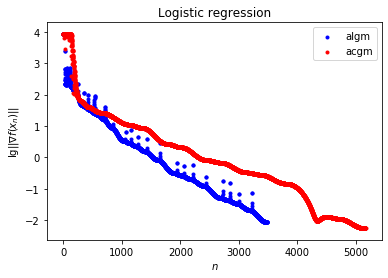

In [14]:
algrun.plot_grads('Logistic regression', log=True)
plt.savefig("./algm_acgm1.eps")

algrun.run_method('acgm', acgm, w, func, grad, L=L, mu=L, eps=eps)

xs=[1/np.sqrt(x) for x in [0.1,0.3,1,10,100,1000]]
ys=[78835,48091,29180,9682,3349,1201]
plt.title('Count calls on \mu')
plt.plot(xs,ys)
plt.scatter(x=xs,y=ys)
plt.xlabel(r'$1/\sqrt{\mu}$')
plt.ylabel('calls of gradient')
plt.savefig('acgm_r.eps')